<!-- <img src="https://s3.amazonaws.com/weclouddata/images/logos/wcd_logo_new_2.png" width="10%"> -->
<h1><center>Street Sign Classification</center></h1>

### Libraries
- PyTorch
- Albumentations
- OpenCV
- NumPy
- Matplotlib

### Prerequisites
- Data Loading
- Data Augmentation
- CNN

### Data
- Train/ Test Data - GTSRB (https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/data)
    - A small portion(10-30%) of this dataset is considered for this task
    - Otherwise incorporating synthetic data will have negligible effect
- Synthetic Street Signs - UK Website (https://www.gov.uk/guidance/traffic-sign-images#images-in-jpg-format)
- Background Data - CityScapes (https://www.cityscapes-dataset.com/dataset-overview/)

## Overview

### Introduction to problem
- In this lab, we will dig deep into how to improve performance of a Deep Neural Network by using synthetic data
- The problem we are considering is Street Sign Classification
- We will conduct 3 different experiments to see the affect of data augmentation and adding synthetic data

### Street Sign Classification
Automatic traffic sign detection and recognition is an
important part of an advanced driver assistance system.
Traffic symbols have several distinguishing features that may
be used for their detection and identification. They are designed
in specific colors and shapes, with the text or symbol in high
contrast to the background. Because traffic signs are generally
oriented upright and facing the camera, the amount of rotational
and geometric distortion is limited.

Information about traffic symbols, such as shape and color,
can be used to place traffic symbols into specific groups;
however, there are several factors that can hinder effective
detection and recognition of traffic signs. These factors include
variations in perspective, variations in illumination (including
variations that are caused by changing light levels, twilight, fog,
and shadowing), occlusion of signs, motion blur, and weather-
worn deterioration of signs. Road scenes are also generally
very cluttered and contain many strong geometric shapes that
could easily be misclassified as road signs. Accuracy is a key
consideration, because even one misclassified or undetected
sign could have an adverse impact on the driver.

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Imports

In [2]:
import copy
import os
import time
from typing import Any, List, Tuple, Union

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from tqdm.notebook import tqdm
import zipfile

In [3]:
# !gdown 1KD360vPQYFuYyo72NWJcZItrhqvODIBu

In [4]:
# !gdown 1gSNDwDL4Q-c4JL5OG_IE1XkhLOMcCM8N

In [5]:
ROOT_DIR = '/data/we_cloud_data/street_sign_classification'

In [6]:
# Helper Functions

def extract_files_from_zip(
    filename: str,
    to_dir: Union[str, os.PathLike]
    ) -> None:
    """
    extracts files from the givez zip file into dir
    """
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall(to_dir)

### GTSRB Data

The German Traffic Sign Benchmark is a multi-class, single-image classification challenge held at the International Joint Conference on Neural Networks (IJCNN) 2011. We cordially invite researchers from relevant fields to participate: The competition is designed to allow for participation without special domain knowledge. Our benchmark has the following properties:

- Single-image, multi-class classification problem
- More than 40 classes
- More than 50,000 images in total
- Large, lifelike database

Extract GTSRB Data

In [7]:
# # Extract GTSRB Files

# gtsrb_path = f'{ROOT_DIR}/gtsrb.zip'
gtsrb_dir = f'{ROOT_DIR}/gtsrb'
# extract_files_from_zip(gtsrb_path, gtsrb_dir)

In [8]:
train_path = f'{ROOT_DIR}/gtsrb/Train'

NUM_CATEGORIES = len(os.listdir(train_path))
# Sample size determines the fraction of training size
SAMPLE_SIZE = 0.1
# Fix the input image dims
IMG_H = 60
IMG_W = 60

# Label Overview
CLASSES = {
    0:'Speed limit (20km/h)',
    1:'Speed limit (30km/h)',
    2:'Speed limit (50km/h)',
    3:'Speed limit (60km/h)',
    4:'Speed limit (70km/h)',
    5:'Speed limit (80km/h)',
    6:'End of speed limit (80km/h)',
    7:'Speed limit (100km/h)',
    8:'Speed limit (120km/h)',
    9:'No passing',
    10:'No passing veh over 3.5 tons',
    11:'Right-of-way at intersection',
    12:'Priority road',
    13:'Yield',
    14:'Stop',
    15:'No vehicles',
    16:'Veh > 3.5 tons prohibited',
    17:'No entry',
    18:'General caution',
    19:'Dangerous curve left',
    20:'Dangerous curve right',
    21:'Double curve',
    22:'Bumpy road',
    23:'Slippery road',
    24:'Road narrows on the right',
    25:'Road work',
    26:'Traffic signals',
    27:'Pedestrians',
    28:'Children crossing',
    29:'Bicycles crossing',
    30:'Beware of ice/snow',
    31:'Wild animals crossing',
    32:'End speed + passing limits',
    33:'Turn right ahead',
    34:'Turn left ahead',
    35:'Ahead only',
    36:'Go straight or right',
    37:'Go straight or left',
    38:'Keep right',
    39:'Keep left',
    40:'Roundabout mandatory',
    41:'End of no passing',
    42:'End no passing veh > 3.5 tons'
}

### Exploring the GTSRB Data

#### Check Class Balancing
Histogram is a great way to check the different occurences of each class

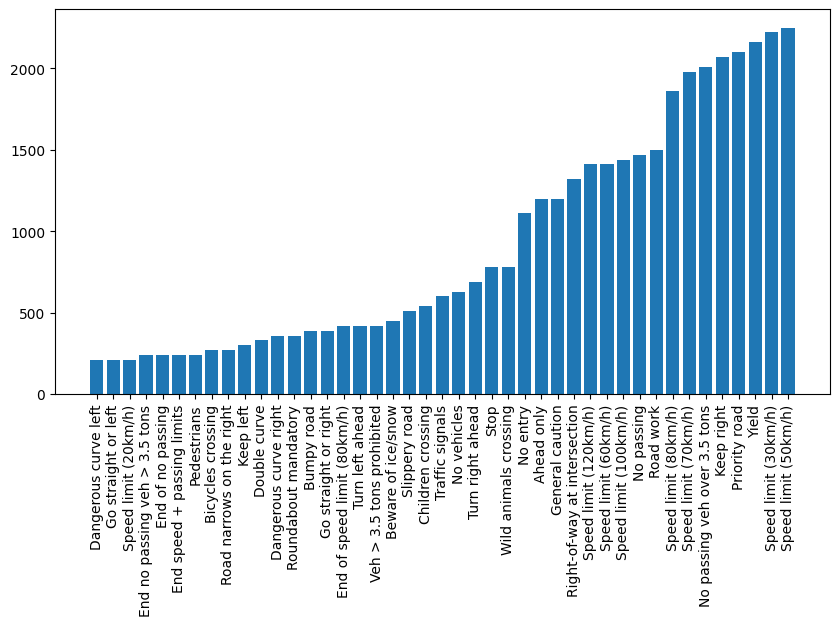

In [9]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(CLASSES[int(folder)])

# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(10,5))
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

Plot Samples from the GTSRB Dataset

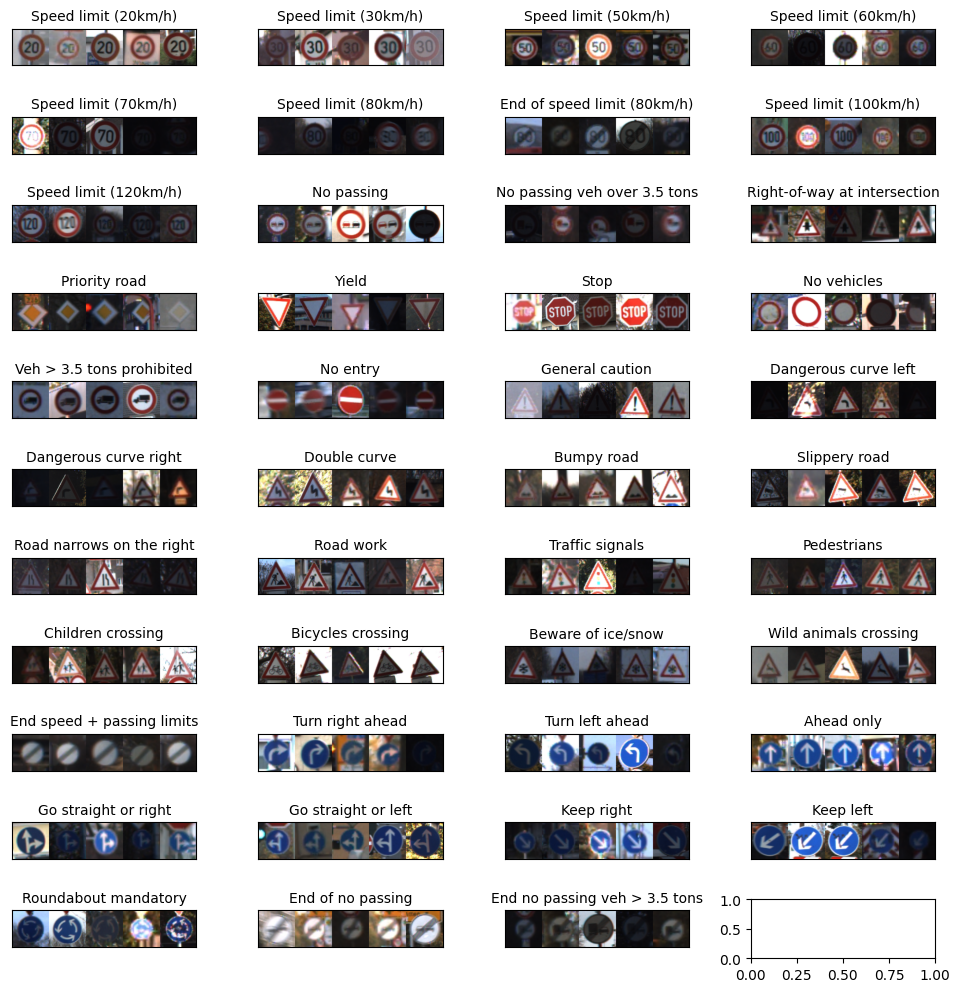

In [10]:
def plot_gtsrb():
    num_cols = 4
    fig, ax = plt.subplots(len(CLASSES) // num_cols + 1, num_cols, figsize=(10,10))
    fig.tight_layout(h_pad = 0)

    for i in CLASSES:
        folder_name = f'{train_path}/{i}'
        filenames = os.listdir(folder_name)
        random.shuffle(filenames)
        concat_imgs = []
        # for each Class ID
        # Get 5 images
        for j in range(5):
            imgName = folder_name + "/" + filenames[j]
            img = cv2.imread(imgName)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (64, 64))
            concat_imgs.append(img)
        # Merge 5 imgs of same class to 1
        concat_img = cv2.hconcat(concat_imgs)
        ax[i//num_cols, (i%num_cols)].imshow(concat_img)
        ax[i//num_cols, (i%num_cols)].set_title(CLASSES[int(i)], fontsize=10)
        ax[i//num_cols, (i%num_cols)].set_yticks([])
        ax[i//num_cols, (i%num_cols)].set_xticks([])
    plt.show()

plot_gtsrb()

### Experiment #1
- Data: GTSRB
- No Data Augmentation

In this experiment, we consider the sample of GTSRB Dataset as is, without any augmentations or extra data annd train a model on it.

Different Sections

1) Dataset Creation
2) Model Definition
3) Model Training and Testing
4) Model Plots

### 1) Create Train/ Val Set
- Divide into 80/ 20
- PyTorch Dataset + PyTorch Dataloader

In [11]:
df_gtsrb = f'{ROOT_DIR}/gtsrb/Train.csv'
df_gtsrb = pd.read_csv(df_gtsrb)
df_gtsrb = df_gtsrb.sample(frac=SAMPLE_SIZE, random_state=1).reset_index(drop=True)
df_gtsrb.head()

Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
0     55      49       6       5      50      44       26   
1     35      35       6       6      30      30       38   
2     56      62       6       5      51      57       13   
3     55      59       6       6      50      54        4   
4     49      50       6       5      44      45       42   

                             Path  
0  Train/26/00026_00014_00005.png  
1  Train/38/00038_00051_00006.png  
2  Train/13/00013_00035_00012.png  
3   Train/4/00004_00018_00020.png  
4  Train/42/00042_00007_00023.png

In [12]:
def get_df_splits(
    df: pd.core.frame.DataFrame,
    sizes: list = [0.8, 0.2],
    shuffle: bool = True
    ) -> Tuple[pd.core.frame.DataFrame]:
    splits = []
    start = 0
    if shuffle:
        df = df.sample(frac= 1).reset_index(drop= True)
    for split_size in sizes:
        len_df = len(df)
        end = start + int(len_df * split_size)
        splits.append(df.iloc[start: end].reset_index(drop= True))
        start = end
    return tuple(splits)

df_gtsrb_train, df_gtsrb_val = get_df_splits(df=df_gtsrb)

#### Create Test Set

In [13]:
df_gtsrb_test = f'{ROOT_DIR}/gtsrb/Test.csv'
df_gtsrb_test = pd.read_csv(df_gtsrb_test)
df_gtsrb_test.head()

Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId            Path
0     53      54       6       5      48      49       16  Test/00000.png
1     42      45       5       5      36      40        1  Test/00001.png
2     48      52       6       6      43      47       38  Test/00002.png
3     27      29       5       5      22      24       33  Test/00003.png
4     60      57       5       5      55      52       11  Test/00004.png

#### Create Pytorch Dataset

In [14]:
class GTSRBDataset(Dataset):
    def __init__(self, df: pd.core.frame.DataFrame, transforms: A.Compose = None):
        super(GTSRBDataset, self).__init__()
        self.df = df
        self.transforms = transforms

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = self._get_image(row)
        label = self._get_label(row)
        return image, label

    def _get_image(self, row):
        image_path = f'{ROOT_DIR}/gtsrb/{row["Path"]}'
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transforms is not None:
            image = self.transforms(image=image)['image'].to(torch.float32)
        return image/255

    def _get_label(self, row):
        class_label = row['ClassId']
        return class_label

    def __len__(self):
        return len(self.df)

Base Transforms to train model

In [15]:
base_transforms = A.Compose(
                [
                    A.Resize(IMG_H, IMG_W),
                    ToTensorV2()
                ]
            )

Create PyTorch DataLoader

In [16]:
dataset_gtsrb_train = GTSRBDataset(df_gtsrb_train, transforms=base_transforms)
dataset_gtsrb_val = GTSRBDataset(df_gtsrb_val, transforms=base_transforms)
dataset_gtsrb_test = GTSRBDataset(df_gtsrb_test, transforms=base_transforms)

dataloader_train = DataLoader(dataset_gtsrb_train, batch_size=64, num_workers=8, drop_last=False)
dataloader_val = DataLoader(dataset_gtsrb_val, batch_size=64, num_workers=8, drop_last=False)
dataloader_test = DataLoader(dataset_gtsrb_test, batch_size=64, num_workers=8, drop_last=False)

#### Plot Training Samples

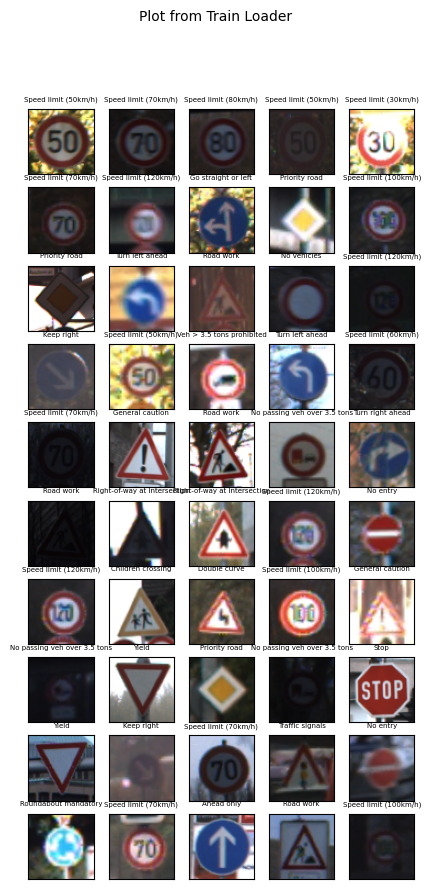

In [17]:
def plot_from_loader(loader, num=50):
    total = 0
    imgs_to_plot = []
    labels_to_plot = []
    for imgs, labels in loader:
        for img, label in zip(imgs, labels):
            img = img.squeeze().movedim(0,-1).numpy()
            imgs_to_plot.append(img)
            labels_to_plot.append(label)
        total += len(labels)
        if total > num:
            break
    fig, ax = plt.subplots(num // 5, 5, figsize=(5,10))
    i = 0
    j = 0
    for img, label in zip(imgs_to_plot[:num], labels_to_plot[:num]):
        ax[i, j].imshow(img)
        ax[i, j].set_title(f'{CLASSES[int(label)]}', fontsize=5)
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        j += 1
        if j == 5:
            j = 0
            i += 1
    plt.suptitle('Plot from Train Loader', fontsize=10)
    plt.show()

plot_from_loader(dataloader_train)

### 2) Model
- A small model is created. This model is fixed accross all experiments
- Num epochs and all other hyperparams are also fixed

In [18]:
class GTSRBModel(nn.Module):
    def __init__(self, in_channels, output_dim, **kwargs):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),
            )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(2304, 1000),
            nn.ReLU(inplace=True),

            nn.Dropout(0.5),
            nn.Linear(in_features=1000, out_features=256),
            nn.ReLU(inplace=True),

            nn.Linear(256, output_dim)
            )

    def forward(self, x):
        x = self.features(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x

In [19]:
# Model Definition

model = GTSRBModel(3, 43).to('cuda')
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [20]:
summary(model, input_size=(3, IMG_H, IMG_W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 30, 30]           1,792
         MaxPool2d-2           [-1, 64, 15, 15]               0
              ReLU-3           [-1, 64, 15, 15]               0
            Conv2d-4          [-1, 128, 15, 15]          73,856
         MaxPool2d-5            [-1, 128, 7, 7]               0
              ReLU-6            [-1, 128, 7, 7]               0
            Conv2d-7            [-1, 256, 7, 7]         295,168
         MaxPool2d-8            [-1, 256, 3, 3]               0
              ReLU-9            [-1, 256, 3, 3]               0
          Dropout-10                 [-1, 2304]               0
           Linear-11                 [-1, 1000]       2,305,000
             ReLU-12                 [-1, 1000]               0
          Dropout-13                 [-1, 1000]               0
           Linear-14                  [

### 3) Model Training and Testing

In [21]:
# Training/ Evaluating Functions

def train(
    model: nn.Module,
    loader: DataLoader,
    opt: Any,
    criterion: Any
    ) -> Tuple[float]:
    """trains the model for one epoch using the loader

    Args:
        model (nn.Module): model to train
        loader (DataLoader): train loader
        opt (Any): optimizer
        criterion (Any): criterion

    Returns:
        Tuple[float]: epoch loss and accuracy
    """
    epoch_loss = 0
    epoch_acc = 0
    # Train the model
    model.train()
    for (images, labels) in loader:
        # print(images)
        images = images.cuda()
        labels = labels.cuda()
        # Training pass
        opt.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        # Backpropagation
        loss.backward()
        # Calculate accuracy
        acc = calculate_accuracy(output, labels)
        # Optimizing weights
        opt.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(loader), epoch_acc / len(loader)

def calculate_accuracy(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    """calculates accuracy bw y_pred and y_true

    Args:
        y_pred (torch.Tensor): predictions
        y_true (torch.Tensor): labels

    Returns:
        float: accuracy
    """
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y_true.view_as(top_pred)).sum()
    acc = correct.float() / y_true.shape[0]
    return acc

def evaluate(
    model: nn.Module,
    loader: DataLoader,
    criterion: Any
    ) -> Tuple[float]:
    """evaluaters model on loader with criterion

    Args:
        model (nn.Module): model to evaluate
        loader (DataLoader): valid loader
        criterion (Any): criterion

    Returns:
        Tuple[float]: loss and accuracy
    """
    epoch_loss = 0
    epoch_acc = 0
    # Evaluate the model
    model.eval()
    with torch.no_grad():
        for (images, labels) in loader:
            images = images.cuda()
            labels = labels.cuda()
            # Run predictions
            output = model(images)
            loss = criterion(output, labels)
            # Calculate accuracy
            acc = calculate_accuracy(output, labels)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(loader), epoch_acc / len(loader)

#### Train Model for 30 epochs

In [22]:
# Perform training

epochs = 30
# List to save training and val loss and accuracies
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

print("Total Training Samples: ", len(dataset_gtsrb_train))
for epoch in tqdm(range(epochs)):
    train_start_time = time.monotonic()
    train_loss, train_acc = train(model, dataloader_train, optimizer, criterion)
    train_end_time = time.monotonic()
    val_start_time = time.monotonic()
    val_loss, val_acc = evaluate(model, dataloader_val, criterion)
    val_end_time = time.monotonic()
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    if (epoch+1) %5 == 0:
        print("Epoch-%d: " % (epoch+1))
        print("Training: Loss = %.4f, Accuracy = %.4f, Time = %.2f seconds" % (train_loss, train_acc, train_end_time - train_start_time))
        print("Validation: Loss = %.4f, Accuracy = %.4f, Time = %.2f seconds" % (val_loss, val_acc, val_end_time - val_start_time))
        print("")

test_loss, test_acc = evaluate(model, dataloader_test, criterion)
print("="*50)
print("Testing: Loss = %.4f, Accuracy = %.4f" % (test_loss, test_acc))
print("="*50)

Total Training Samples:  3136


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch-5: 
Training: Loss = 2.2000, Accuracy = 0.3182, Time = 0.30 seconds
Validation: Loss = 2.0740, Accuracy = 0.3413, Time = 0.19 seconds

Epoch-10: 
Training: Loss = 1.5766, Accuracy = 0.4659, Time = 0.32 seconds
Validation: Loss = 1.5625, Accuracy = 0.4712, Time = 0.19 seconds

Epoch-15: 
Training: Loss = 1.0565, Accuracy = 0.6339, Time = 0.30 seconds
Validation: Loss = 1.0465, Accuracy = 0.6418, Time = 0.17 seconds

Epoch-20: 
Training: Loss = 0.6105, Accuracy = 0.7930, Time = 0.30 seconds
Validation: Loss = 0.5605, Accuracy = 0.8305, Time = 0.18 seconds

Epoch-25: 
Training: Loss = 0.3701, Accuracy = 0.8728, Time = 0.31 seconds
Validation: Loss = 0.4069, Accuracy = 0.8786, Time = 0.17 seconds

Epoch-30: 
Training: Loss = 0.2773, Accuracy = 0.9107, Time = 0.30 seconds
Validation: Loss = 0.3852, Accuracy = 0.8894, Time = 0.18 seconds

Testing: Loss = 0.8334, Accuracy = 0.7822


### 4) Model Plots

In [23]:
# Plot helper functions

def plot_history(ax, history_list, label_list):
    for history, label in zip(history_list, label_list):
        ax.plot(history, label=label)
    ax.legend()

def plot():
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    plot_history(ax[0], [train_loss_list, val_loss_list], ['train_loss_list', 'val_loss_list'])
    ax[0].set_title('Loss')
    plot_history(ax[1], [train_acc_list, val_acc_list], ['train_acc_list', 'val_acc_list'])
    ax[1].set_title('Accuracy')
    plt.show()

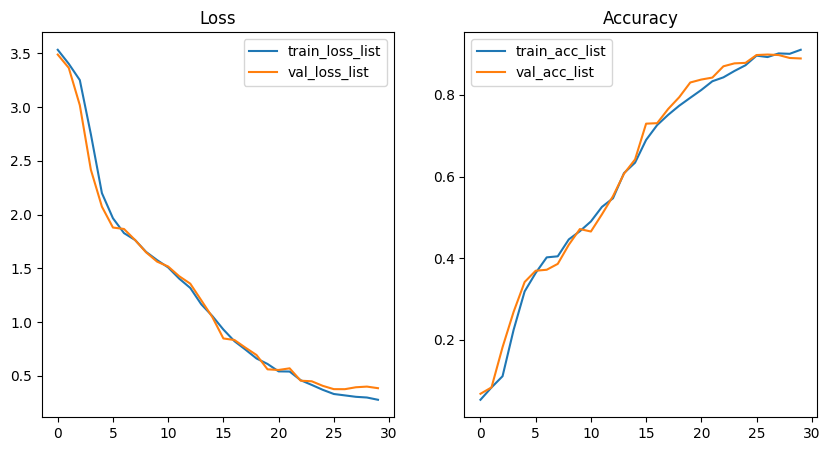

In [24]:
# Plot loss and metric list

plot()

---
---

#### Let's get away from the basics and create an Experiment Class to do all the things above which encapsulates all these functions

This class will be used to conduct all experiments, save its results and compare them

In [25]:
class Experiment:
    def __init__(
        self,
        name: str,
        df: pd.core.frame.DataFrame,
        config: dict,
        ):
        self.name = name
        self.df = df
        self.model_config = config['model_config']
        self.training_config = config['training_config']
        self.dataloading_config = config['dataloading_config']
        self.dataset_config = config['dataset_config']
        self.device = config['device']
        self.val_loss_list = []
        self.val_metric_list = []
        self.train_loss_list = []
        self.train_metric_list = []
        self.test_loss = None
        self.test_metric = None
        self.save_dir = f'{ROOT_DIR}/models'
        self.df = self._get_df(self.df)

    def _get_df(self, df: Union[str, pd.core.frame.DataFrame]):
        """get df from passed argument

        Args:
            df (str or pd.core.frame.DataFrame): _description_

        Returns:
            Loaded pd DataFrame
        """
        if isinstance(df, str):
            df = pd.read_csv(df)
        return df

    def _get_test_df(self):
        """get test df

        Returns:
            pd Dataframe
        """
        test_df = self._get_df(f'{ROOT_DIR}/gtsrb/Test.csv')
        return test_df

    def _get_df_splits(self) -> Tuple[pd.core.frame.DataFrame]:
        """splits the df bases on the size list

        Returns:
            Tuple[pd.core.frame.DataFrame]
        """
        df = self.df.copy()
        sizes = self.dataset_config['sizes']
        splits = []
        start = 0
        len_df = len(df)
        for split_size in sizes:
            end = start + int(len_df * split_size)
            splits.append(df.iloc[start: end].reset_index(drop= True))
            start = end
        return splits

    def _get_dataloader(self, df: pd.core.frame.DataFrame) -> DataLoader:
        """gets the dataloader from the df

        Args:
            df (pd.core.frame.DataFrame): df

        Returns:
            DataLoader: PyTorch DataLoader
        """
        dataset = GTSRBDataset(df, transforms=self.dataset_config['transforms'])
        dataloader = DataLoader(dataset, **self.dataloading_config)
        return dataloader

    def _get_test_dataloader(self, df: pd.core.frame.DataFrame) -> DataLoader:
        """returns the test dataloader

        Args:
            df (pd.core.frame.DataFrame): test df

        Returns:
            DataLoader: DataLoader with base transforms
        """
        dataset = GTSRBDataset(df, transforms=base_transforms)
        dataloader = DataLoader(dataset, **self.dataloading_config)
        return dataloader

    def _get_model(self) -> nn.Module:
        """returns the model bases on the model config
        Loads the class from class name
        Loads the hyperparameters from model config config
        Loads the model weights from model weight paths

        Returns:
            nn.Module: Class loaded from Model name
        """
        model_class = globals()[self.model_config['name']]
        model = model_class(**self.model_config['config'])
        if self.model_config['weights_path'] is not None:
            try:
                state_dict_path = self.model_config['weights_path']
                model.load_state_dict(torch.load(state_dict_path))
            except Exception as e:
                print('Failed to read state dict. Not loading model weights: ', e)
        model = model.to(self.device)
        return model

    def _save_model(self, model: nn.Module):
        """saves the state dict at the save_dir path

        Args:
            model (nn.Module): model to be saved
        """
        state_dict = model.state_dict()
        save_path = f'{self.save_dir}/{self.name}.pth'
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)
        torch.save(state_dict, save_path)

    def _update_model_config(self):
        """updates the model config after training
        """
        self.model_config['weights_path'] = f'{self.save_dir}/{self.name}.pth'

    def _get_optimizer(self, model: nn.Module) -> Any:
        """returns the PyTorch Optimizer from config
        Parameters loaded are the model parameters

        Args:
            model (nn.Module): model to optimize

        Returns:
            optim: Optimizer
        """
        optimizer_name = self.training_config['optimizer']['name']
        optimizer_config = self.training_config['optimizer']['config']
        optimizer_cls = getattr(optim, optimizer_name)
        optimizer = optimizer_cls(
                        params = model.parameters(),
                        **optimizer_config
                    )
        return optimizer

    def _get_criterion(self) -> Any:
        """returns the criterion loaded from training config

        Returns:
            Any: Criterion
        """
        criterion_name = self.training_config['criterion']['name']
        criterion_config = self.training_config['criterion']['config']
        criterion_cls = getattr(nn, criterion_name)
        criterion = criterion_cls(**criterion_config)
        return criterion

    def train(self):
        """
        Training Loop
        """
        model = self._get_model()
        optimizer = self._get_optimizer(model)
        criterion = self._get_criterion()
        df_train, df_val = self._get_df_splits()
        dataloader_train = self._get_dataloader(df_train)
        dataloader_val = self._get_dataloader(df_val)
        num_epochs = self.training_config['num_epochs']
        print("Total Training Samples: ", len(df_train))
        for epoch in tqdm(range(num_epochs)):
            train_start_time = time.monotonic()
            # Train one epoch
            train_loss, train_metric = self._train_one_epoch(model, dataloader_train, optimizer, criterion)
            train_end_time = time.monotonic()
            val_start_time = time.monotonic()
            # Validate
            val_loss, val_metric = self._evaluate(model, dataloader_val, criterion)
            val_end_time = time.monotonic()
            # Append loss and accuracy to class lists
            self.train_loss_list.append(train_loss)
            self.train_metric_list.append(train_metric)
            self.val_loss_list.append(val_loss)
            self.val_metric_list.append(val_metric)
            # Prints
            if (epoch+1) % 5 == 0:
                print("Epoch-%d: " % (epoch+1))
                print("Training: Loss = %.4f, Accuracy = %.4f, Time = %.2f seconds"\
                    % (train_loss, train_metric, train_end_time - train_start_time))
                print("Validation: Loss = %.4f, Accuracy = %.4f, Time = %.2f seconds"\
                    % (val_loss, val_metric, val_end_time - val_start_time))
                print("")
        self._save_model(model)
        self._update_model_config()
        print("="*50)

    def _train_one_epoch(
        self,
        model: nn.Module,
        dataloader: DataLoader,
        optimizer: Any,
        criterion: Any,
        ):
        """Trains the model for one epoch

        Args:
            model (nn.Module): model to train
            dataloader (DataLoader): train dataloader
            optimizer (Any)
            criterion (Any)

        Returns:
            epoch loss and epoch accuracy
        """
        epoch_loss = 0
        epoch_acc = 0
        # Train the model
        model.train()
        for (images, labels) in dataloader:
            images = images.to(self.device)
            labels = labels.to(self.device)
            # Training pass
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            # Backpropagation
            loss.backward()
            # Calculate accuracy
            acc = self._calculate_accuracy(output, labels)
            # Optimizing weights
            optimizer.step()
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

    def _calculate_accuracy(self, y_pred: torch.Tensor, y_true: torch.Tensor):
        """calculates the accuracy from y_pred and y_true
        Calculates argmax of y_pred to get predicted class

        Args:
            y_pred (torch.Tensor): predictions
            y_true (torch.Tensor): actual ouput

        Returns:
            accuracy: float
        """
        top_pred = y_pred.argmax(1, keepdim = True)
        correct = top_pred.eq(y_true.view_as(top_pred)).sum()
        acc = correct.float() / y_true.shape[0]
        return acc

    def _make_predictions(
        self,
        model: nn.Module,
        loader: DataLoader
        ) -> Tuple[torch.Tensor]:
        """Makes the prediction of model on loader

        Args:
            model (nn.Module): model to make predictions
            loader (DataLoader): loader to make predictions on

        Returns:
            Tuple[torch.Tensor]: all_outputs and all_labels
        """
        all_labels = None
        all_outputs = None
        # Evaluate the model
        model.eval()
        with torch.no_grad():
            for (images, labels) in loader:
                images = images.to(self.device)
                labels = labels.to(self.device)
                # Run predictions
                output = model(images)
                if all_outputs is not None:
                    all_outputs = torch.cat([all_outputs, output])
                else:
                    all_outputs = output
                if all_labels is not None:
                    all_labels = torch.cat([all_labels, labels])
                else:
                    all_labels = labels
        return all_outputs, all_labels

    def _evaluate(
        self,
        model: nn.Module,
        loader: DataLoader,
        criterion: Any
        ) -> Tuple[float]:
        """_summary_

        Args:
            model (nn.Module): _description_
            loader (DataLoader): _description_
            criterion (Any): _description_

        Returns:
            Tuple[float]: _description_
        """
        output, labels = self._make_predictions(model, loader)
        val_metric = self._calculate_accuracy(output, labels).item()
        val_loss = criterion(output, labels).item()
        return val_loss, val_metric

    def test(self):
        """Testing loop
        Test on Test Dataset
        """
        model = self._get_model()
        criterion = self._get_criterion()
        df_test = self._get_test_df()
        dataloader_test = self._get_test_dataloader(df_test)
        output, labels = self._make_predictions(model, dataloader_test)
        test_metric = self._calculate_accuracy(output, labels).item()
        test_loss = criterion(output, labels)
        print("Testing: Loss = %.4f, Accuracy = %.4f" % (test_loss, test_metric))
        self.test_loss = test_loss
        self.test_metric = test_metric
        print("="*50)

    def _plot_history(self, ax, history_list: List[np.ndarray], label_list: List[str]):
        """plots the list of histories titles as label list

        Args:
            ax : plt axis
            history_list (List[np.ndarray]): List of histories to plot
            label_list (List[str]): labels of each history
        """
        for history, label in zip(history_list, label_list):
            ax.plot(history, label=label)
        ax.legend()
        ax.set_title(label_list[0].split('_')[1])

    def plot_confusion_matrix(self, ax=None):
        """plots confustion Matrix

        Args:
            ax (plt axis, optional). Defaults to None.
        """
        print('='*50)
        print('Confusion Matrix on Test Set')
        print('='*50)
        model = self._get_model()
        df_test = self._get_test_df()
        dataloader_test = self._get_test_dataloader(df_test)
        output, labels = self._make_predictions(model, dataloader_test)
        output = output.argmax(1, keepdim = True).cpu().detach().numpy()
        labels = labels.cpu().detach().numpy()
        cf = confusion_matrix(labels, output)
        df_cm = pd.DataFrame(cf, index = CLASSES,  columns = CLASSES)
        plt.figure(figsize = (10,10))
        if ax is None:
            sns.heatmap(df_cm, annot=True)
        else:
            sns.heatmap(df_cm, annot=True, ax=ax)

    def plot_from_train_loader(self, num=50):
        """plot samples from train loader

        Args:
            num (int, optional): maximum plot samples. Defaults to 50.
        """
        df_train, df_val = self._get_df_splits()
        loader = self._get_dataloader(df_train)
        total = 0
        imgs_to_plot = []
        labels_to_plot = []
        for imgs, labels in loader:
            for img, label in zip(imgs, labels):
                img = img.squeeze().movedim(0,-1).numpy()
                imgs_to_plot.append(img)
                labels_to_plot.append(label)
            total += len(labels)
            if total > num:
                break
        fig, ax = plt.subplots(num // 5, 5, figsize=(5,10))
        i = 0
        j = 0
        for img, label in zip(imgs_to_plot[:num], labels_to_plot[:num]):
            ax[i, j].imshow(img)
            ax[i, j].set_title(f'{CLASSES[int(label)]}', fontsize=5)
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            j += 1
            if j == 5:
                j = 0
                i += 1
        plt.suptitle('Plot from Train Loader', fontsize=10)
        plt.show()

    def plot_lists(self):
        """plots train/ val loss and metric lists
        """
        print('='*50)
        print('Accuracy and Loss Curves')
        print('='*50)
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        self._plot_history(ax[0], [self.train_loss_list, self.val_loss_list], ['train_loss_list', 'val_loss_list'])
        ax[1].set_title('Loss')
        self._plot_history(ax[1], [self.train_metric_list, self.val_metric_list], ['train_metric_list', 'val_metric_list'])
        ax[1].set_title('Accuracy')
        plt.show()

    def run_experiment(self):
        """
        1) Plots samples from train loader
        2) Trains the model
        3) Tests the trained model
        4) Plots the histories
        5) Plots confuction matrix on test set
        """
        self.plot_from_train_loader()
        self.train()
        self.test()
        self.plot_lists()
        self.plot_confusion_matrix()

#### Running Exp 1 from the newly created class

Experiment Config

In [26]:
experiment_1_config = {
    'name': 'experiment_1',
    'df': df_gtsrb,
    'config': {
        'model_config': {
            'name': 'GTSRBModel',
            'weights_path': None,
            'config':{
                'in_channels': 3,
                'output_dim': 43,
            }
        },
        'training_config': {
            'num_epochs': 30,
            'optimizer': {
                'name': 'Adam',
                'config': {
                    'lr': 0.001,
                },
            },
            'criterion': {
                'name': 'CrossEntropyLoss',
                'config': {},
            },
        },
        'dataloading_config': {
            'shuffle': True,
            'batch_size': 64,
            'drop_last': False,
            'num_workers': 2,
        },
        'dataset_config': {
            'sizes': [0.8, 0.2],
            'transforms': base_transforms,
        },
        'device': 'cuda',
    },
}

experiment_1 = Experiment(**experiment_1_config)

Run Experiment

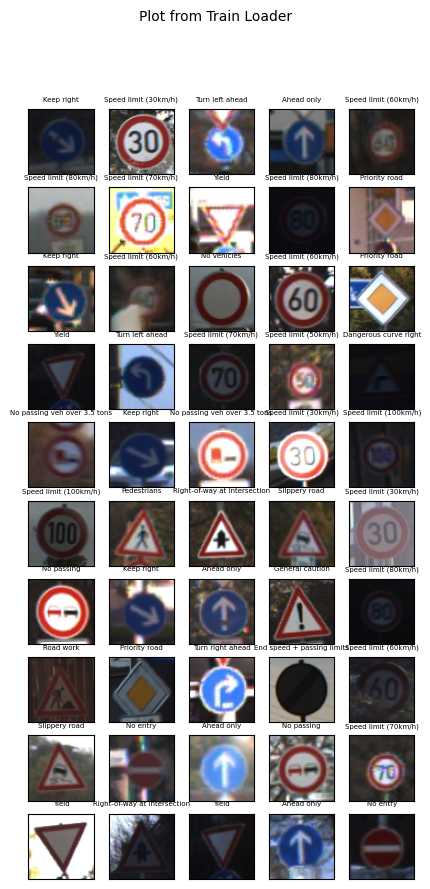

Total Training Samples:  3136


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch-5: 
Training: Loss = 2.5594, Accuracy = 0.2366, Time = 0.27 seconds
Validation: Loss = 2.3559, Accuracy = 0.2895, Time = 0.11 seconds

Epoch-10: 
Training: Loss = 1.4876, Accuracy = 0.4882, Time = 0.28 seconds
Validation: Loss = 1.5373, Accuracy = 0.4834, Time = 0.11 seconds

Epoch-15: 
Training: Loss = 1.0444, Accuracy = 0.6330, Time = 0.28 seconds
Validation: Loss = 1.1140, Accuracy = 0.6237, Time = 0.12 seconds

Epoch-20: 
Training: Loss = 0.6296, Accuracy = 0.7889, Time = 0.28 seconds
Validation: Loss = 0.7054, Accuracy = 0.7628, Time = 0.11 seconds

Epoch-25: 
Training: Loss = 0.3515, Accuracy = 0.8801, Time = 0.28 seconds
Validation: Loss = 0.4597, Accuracy = 0.8673, Time = 0.11 seconds

Epoch-30: 
Training: Loss = 0.2195, Accuracy = 0.9251, Time = 0.28 seconds
Validation: Loss = 0.3687, Accuracy = 0.8954, Time = 0.11 seconds

Testing: Loss = 0.8211, Accuracy = 0.8047
Accuracy and Loss Curves


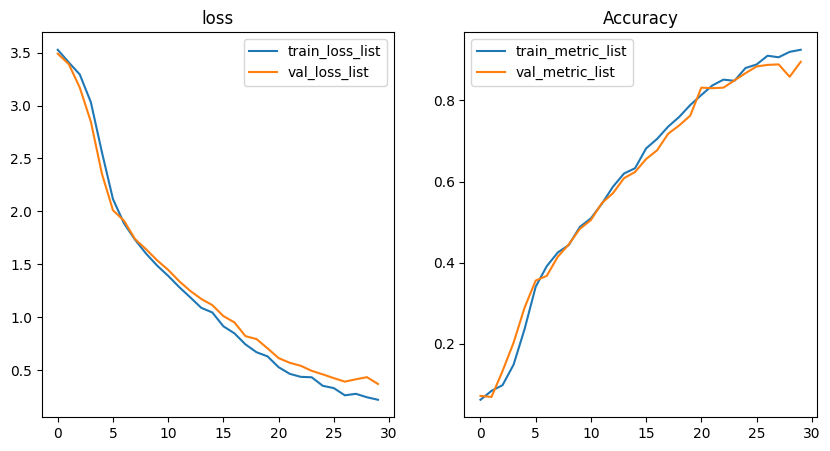

Confusion Matrix on Test Set


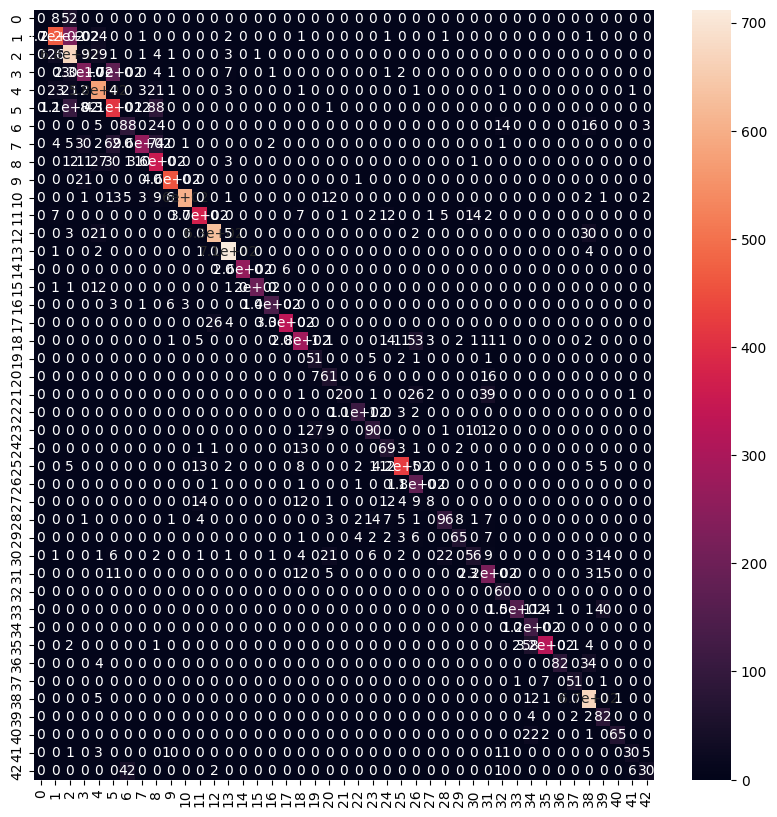

In [27]:
experiment_1.run_experiment()

### Experiment #2
- Data: GTSRB
- Data Augmentation

In this experiment, we consider the sample of GTSRB Dataset, augment them with some augmentation and train a model on the augmented data

### Data Augmentations
- Augmentations using Albumentations
- Visualize images after aug

Visualizing Augmentations

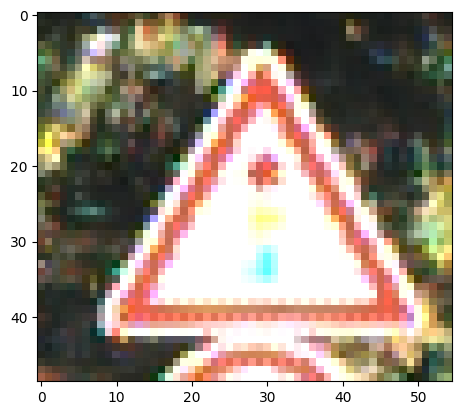

In [28]:
sample_img = f'{gtsrb_dir}/{df_gtsrb.iloc[0]["Path"]}'
sample_img = cv2.imread(sample_img)
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

In [29]:
def transform_and_plot(img, transform, times=10):
    plt.figure(figsize = (10, 20))
    transformed_imgs = []
    for _ in range(times):
        transformed = transform(image=img)['image']
        transformed_imgs.append(transformed)
    transformed_imgs = cv2.hconcat(transformed_imgs)
    plt.imshow(transformed_imgs)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [30]:
augmentations = [
    # Transform Img Shape
    # ---------------------
    A.Resize(IMG_H, IMG_W),
    A.ElasticTransform(p=1),
    A.GridDistortion(p=1),
    A.Perspective(p=1),
    A.ShiftScaleRotate(p=1),
    # ----------------------
    # Transform Img Style
    A.CLAHE(p=1),
    A.ColorJitter(p=1),
    A.RGBShift(p=1),
    A.RandomBrightnessContrast(p=1),
    A.FancyPCA(p=1),
    A.RandomFog(p=1),
    A.RandomShadow(p=1),
    # ----------------------
    # Noise
    A.RandomGamma(p=1),
    A.GaussNoise(p=1),
    # ----------------------
    # Blur
    A.Blur(p=1),
    A.MotionBlur(p=1),
    A.Sharpen(p=1),
]

/mnt/dda9e6d5-2e19-4471-bd3e-d80079ee1283/data/we_cloud_data/.venv/lib/python3.12/site-packages/albumentations/core/validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Resize


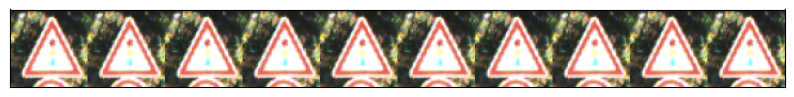

ElasticTransform


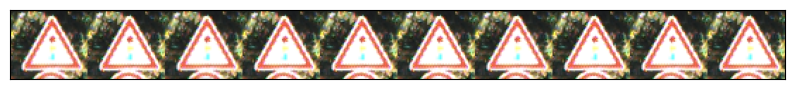

GridDistortion


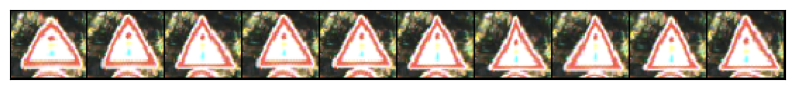

Perspective


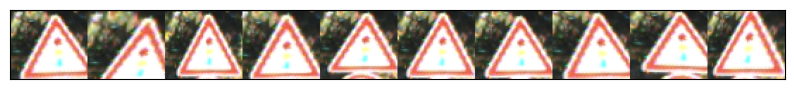

ShiftScaleRotate


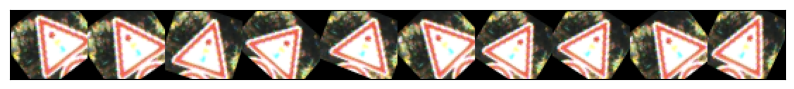

CLAHE


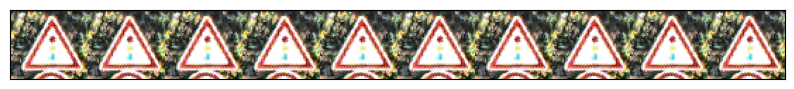

ColorJitter


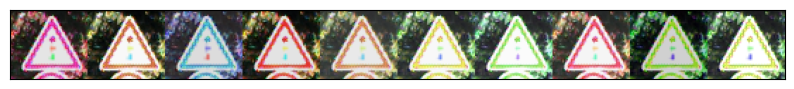

RGBShift


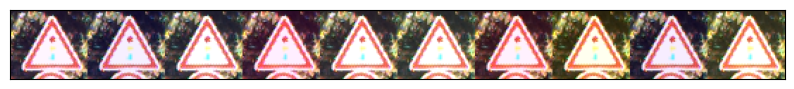

RandomBrightnessContrast


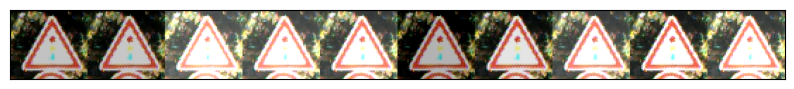

FancyPCA


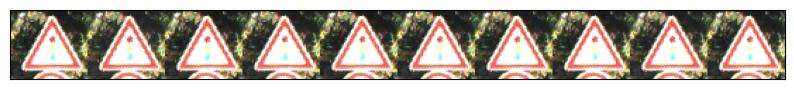

RandomFog


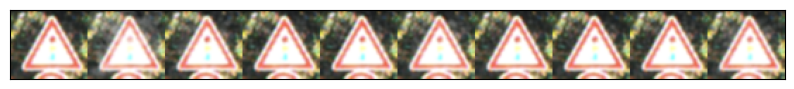

RandomShadow


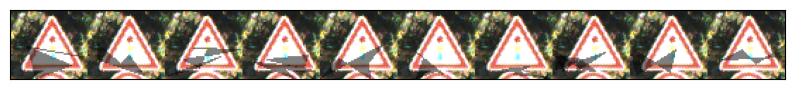

RandomGamma


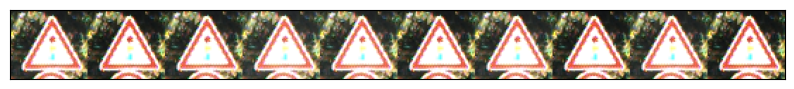

GaussNoise


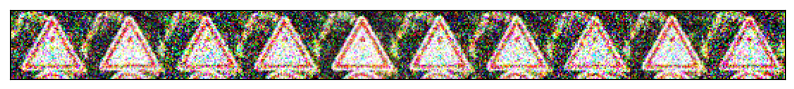

Blur


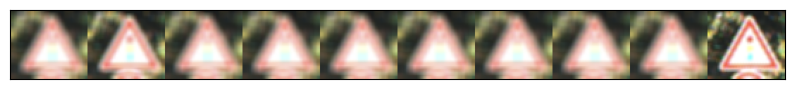

MotionBlur


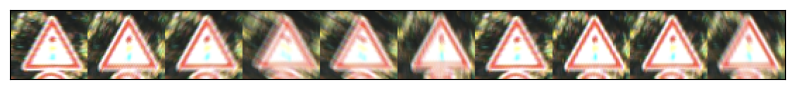

Sharpen


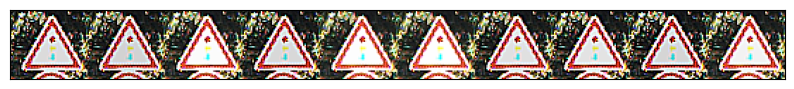

In [31]:
for aug in augmentations:
    print(aug.__class__.__name__)
    transform_and_plot(sample_img, aug)

Select a few of them for training augmentations

In [32]:
train_transform = A.Compose(
    [
        A.Resize(IMG_H, IMG_W),
        A.CLAHE(p=0.2),
        A.ColorJitter(p=0.2),
        A.RandomGamma(p=0.2),
        A.RGBShift(p=0.2),
        A.RandomBrightnessContrast(p=0.2),
        ToTensorV2(),
    ]
)

#### Create Experiment

In [33]:
experiment_2_config = {
    'name': 'experiment_2',
    'df': df_gtsrb,
    'config': {
        'model_config': {
            'name': 'GTSRBModel',
            'weights_path': None,
            'config':{
                'in_channels': 3,
                'output_dim': 43,
            }
        },
        'training_config': {
            'num_epochs': 30,
            'optimizer': {
                'name': 'Adam',
                'config': {
                    'lr': 0.001,
                },
            },
            'criterion': {
                'name': 'CrossEntropyLoss',
                'config': {},
            },
        },
        'dataloading_config': {
            'shuffle': True,
            'batch_size': 64,
            'drop_last': False,
            'num_workers': 2,
        },
        'dataset_config': {
            'sizes': [0.8, 0.2],
            'transforms': train_transform,
        },
        'device': 'cuda',
    }
}

experiment_2 = Experiment(**experiment_2_config)

Run Experiment

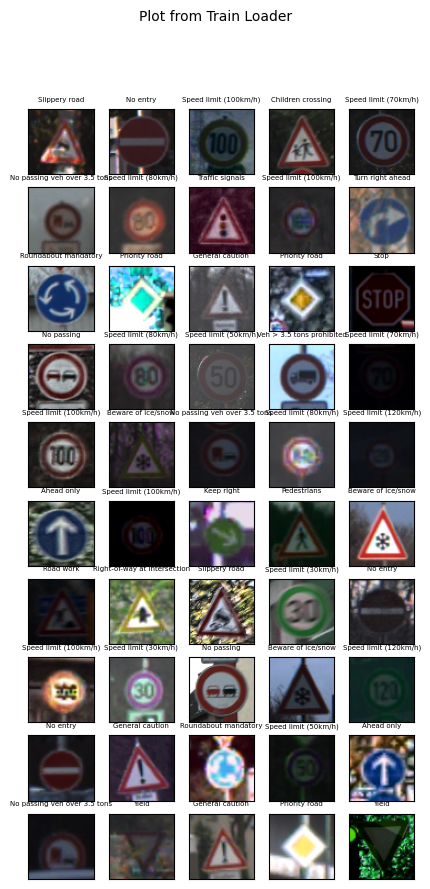

Total Training Samples:  3136


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch-5: 
Training: Loss = 2.9821, Accuracy = 0.1703, Time = 0.39 seconds
Validation: Loss = 2.8317, Accuracy = 0.2079, Time = 0.15 seconds

Epoch-10: 
Training: Loss = 1.6447, Accuracy = 0.4528, Time = 0.39 seconds
Validation: Loss = 1.5491, Accuracy = 0.4949, Time = 0.15 seconds

Epoch-15: 
Training: Loss = 0.8841, Accuracy = 0.7079, Time = 0.38 seconds
Validation: Loss = 0.7742, Accuracy = 0.7436, Time = 0.14 seconds

Epoch-20: 
Training: Loss = 0.5202, Accuracy = 0.8320, Time = 0.39 seconds
Validation: Loss = 0.4983, Accuracy = 0.8571, Time = 0.14 seconds

Epoch-25: 
Training: Loss = 0.3674, Accuracy = 0.8811, Time = 0.39 seconds
Validation: Loss = 0.3451, Accuracy = 0.9005, Time = 0.15 seconds

Epoch-30: 
Training: Loss = 0.2539, Accuracy = 0.9120, Time = 0.39 seconds
Validation: Loss = 0.2778, Accuracy = 0.9069, Time = 0.14 seconds

Testing: Loss = 0.4348, Accuracy = 0.8774
Accuracy and Loss Curves


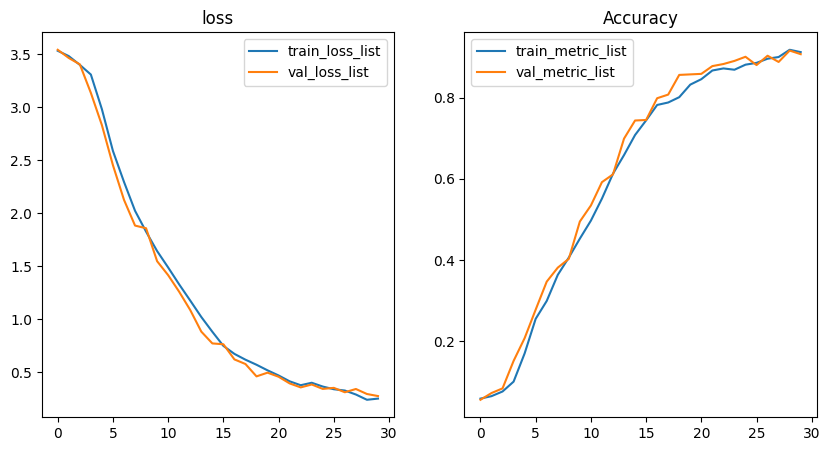

Confusion Matrix on Test Set


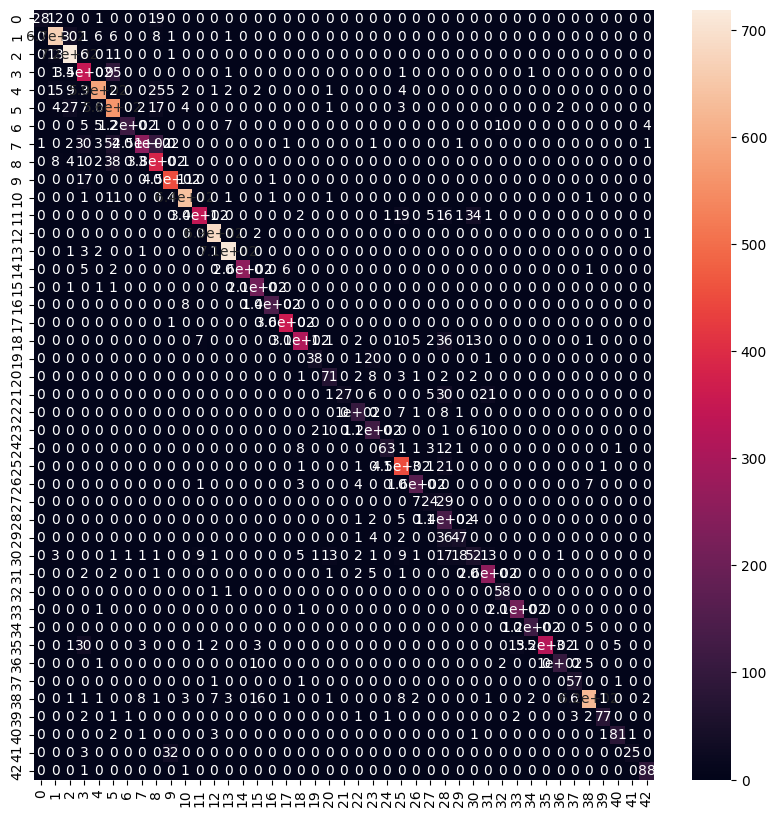

In [34]:
experiment_2.run_experiment()

## Experiment #3
- Data: GTSRB + Synthetic data
- Data Augmentation

### Create Synthetic Data
- J. Greenhalgh and M. Mirmehdi, "Real-Time Detection and Recognition of Road Traffic Signs," in IEEE Transactions on Intelligent Transportation Systems, vol. 13, no. 4, pp. 1498-1506, Dec. 2012, doi: 10.1109/TITS.2012.2208909.

Training the classifiers on all possible road signs is essential
to avoid misclassification of unknown signs. However, gath-
ering a sufficient amount of real data on which to train the
classifiers is difficult and time consuming, given the sheer
number of different existing signs and the scarcity of particular
signs.

Therefore why we resort to creation of street signs synthetically

Process:

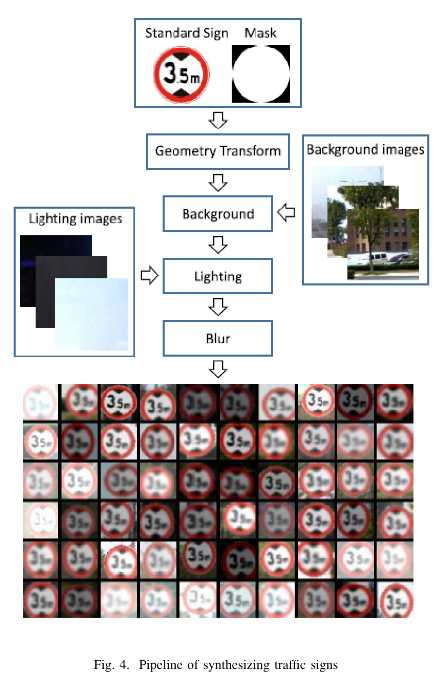

#### Meta Dataset

In [35]:
class SyntheticDataGenerator:
    def __init__(
        self,
        df_path,
        dataset_meta,
        dataset_background,
        ):
        self.dataset_meta = dataset_meta
        self.dataset_background = dataset_background
        self.df_path = df_path
        self.df = self._get_df(df_path)
        self.root_dir = f'{ROOT_DIR}/gtsrb'
        self.save_dir = 'Generated'

    def _get_df(self, df_path: Union[str, pd.core.frame.DataFrame]) -> pd.core.frame.DataFrame:
        """returns df

        Args:
            df_path (Union[str, pd.core.frame.DataFrame])

        Returns:
            df: Loaded pd DataFrame
        """
        # try:
            # df = pd.read_csv(df_path)
        # except:
        df = pd.DataFrame(columns=['Path', 'ClassId'])
        return df

    def _save_df(self):
        """Saves df to csv
        """
        self.df.to_csv(self.df_path, index=False)

    def _update_df(self, idx: int, class_id: int):
        """updates df with another row of Path and ClassID

        Args:
            idx (int): index of save path
            class_id (int): class ID
        """
        update_df = pd.DataFrame(
            {
                'Path': [f'{self.save_dir}/{class_id}/{idx}.png'],
                'ClassId': [class_id]
            }
        )
        self.df = pd.concat([self.df, update_df])

    def generate(
        self,
        class_id: int,
        num_samples: int,
        save: str= False
        ) -> List[np.ndarray]:
        """Generates num_sample images for class_id

        Args:
            class_id (int): class ID of images to generate
            num_samples (int): total samples to generate
            save (str, optional): save or not to save generated images. Defaults to False.

        Returns:
            List[np.ndarray]: generated images
        """
        generated_images = []
        while len(generated_images) < num_samples:
            try:
                image = self._get_meta_image(class_id)
                mask = self._get_meta_mask(image)
                background = self._get_random_background()
                generated_image = self._superimpose_image(image, background, mask)
                generated_images.append(generated_image)
            except Exception as e:
                print(e, 'skipping image')
        if save:
            self._save_images(generated_images, class_id)
        return generated_images

    def _get_meta_image(self, class_id: int) -> np.ndarray:
        """gets the meta image by its class ID

        Args:
            class_id (int): class ID of meta image

        Returns:
            np.ndarray: meta image
        """
        meta_img = None
        for img, label in self.dataset_meta:
            # If label == class id, then we found its meta image
            if label == class_id:
                meta_img = img
        return meta_img.movedim(0,-1).numpy()

    def _get_meta_mask(self, image: np.ndarray) -> np.ndarray:
        """gets mask of meta image

        Args:
            image (np.ndarray): image to get the mask from

        Returns:
            np.ndarray: _description_
        """
        mask = copy.deepcopy(image)
        mask = mask - mask[0]
        mask[mask > 0] = 1
        mask = self._get_largest_contour(mask)
        return mask

    def _get_largest_contour(self, mask: np.ndarray) -> np.ndarray:
        """gets largest contour of the mask

        Args:
            mask (np.ndarray): mask

        Returns:
            np.ndarray: mask filled with largest contour
        """
        empty_mask = np.zeros_like(mask).astype(np.uint8)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY).astype(np.uint8)*255
        _, mask = cv2.threshold(mask,244,255,cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(mask,
        cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        largest_contour = sorted(contours, key=cv2.contourArea, reverse=True)[0]
        cv2.drawContours(empty_mask, [largest_contour], -1, (1, 1, 1), -1)
        return empty_mask

    def _get_random_background(self) -> np.ndarray:
        """get random background from background dataset

        Returns:
            np.ndarray: background image
        """
        len_dataset = len(self.dataset_background)
        # Choose random index
        random_idx = np.random.randint(0, len_dataset)
        background_img, background_mask = self.dataset_background[random_idx]
        return background_img.movedim(0,-1).numpy()

    def _superimpose_image(
        self,
        image: np.ndarray,
        background: np.ndarray,
        binary_mask: np.ndarray
        ) -> np.ndarray:
        """Superimpose meta image over background image using mask of meta image

        Args:
            image (np.ndarray): meta image
            background (np.ndarray): background image
            binary_mask (np.ndarray): mask of meta image

        Returns:
            np.ndarray: superimposed image
        """
        image = image * binary_mask
        background = background * (1 - binary_mask)
        superimposed_image = image.astype(float) + background.astype(float)
        return superimposed_image

    def _save_images(self, generated_images: List[np.ndarray], class_id: int):
        """saves images into self.save_dir

        Args:
            generated_images (List[np.ndarray]): list of generated images
            class_id (int): class index of generated images
        """
        if not os.path.exists(f'{self.root_dir}/{self.save_dir}'):
            os.mkdir(f'{self.root_dir}/{self.save_dir}')
        class_dir = f'{self.root_dir}/{self.save_dir}/{class_id}'
        if not os.path.exists(class_dir):
            os.mkdir(class_dir)
        item_idx = 0
        for img in generated_images:
            file_name = f'{class_dir}/{item_idx}.png'
            cv2.imwrite(file_name, cv2.cvtColor((img*255).astype(np.uint8), cv2.COLOR_RGB2BGR))
            self._update_df(item_idx, class_id)
            item_idx += 1
        self._save_df()

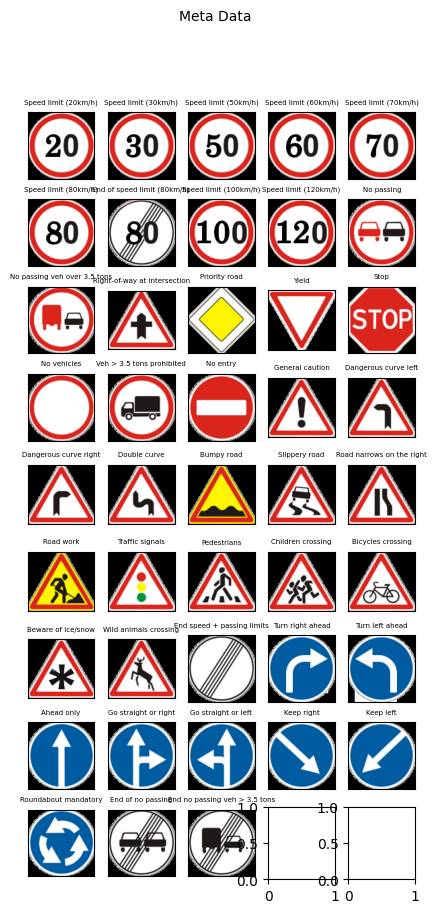

In [36]:
meta_path = f'{ROOT_DIR}/gtsrb/Meta'
def plot_meta():
    fig, ax = plt.subplots(len(CLASSES) // 5 + 1, 5, figsize=(5,10))
    i = 0
    j = 0
    for idx in range(len(CLASSES)):
        img_path = f'{meta_path}/{idx}.png'
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i, j].imshow(img)
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        ax[i, j].set_title(CLASSES[idx], fontsize=5)
        j += 1
        if j == 5:
            j = 0
            i += 1
    plt.suptitle('Meta Data', fontsize=10)
    plt.show()

plot_meta()

In [37]:
meta_transforms = A.Compose(
    [
        A.Resize(60, 60),
        A.PadIfNeeded(min_height=IMG_H, min_width=IMG_W, border_mode=cv2.BORDER_CONSTANT, value=(0.,0.,0.)),
        A.Perspective(p=0.9),
        A.OneOf(
          [
            A.MotionBlur(p=1),
            A.Blur(p=1),
          ],
        p=0.85),
        A.CLAHE(p=0.5),
        A.RandomGamma(p=0.5),
        A.RandomBrightnessContrast(p=1),
        A.GridDistortion(p=0.3, distort_limit=0.15),
        ToTensorV2(),
    ]
)

dataset_meta = GTSRBDataset(
    df=pd.read_csv(f'{ROOT_DIR}/gtsrb/Meta.csv'),
    transforms=meta_transforms,
)

/tmp/ipykernel_53252/2571543862.py:4: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=IMG_H, min_width=IMG_W, border_mode=cv2.BORDER_CONSTANT, value=(0.,0.,0.)),


#### Background Dataset

In [38]:
# Extract GTSRB Files

cityscapes_path = f'{ROOT_DIR}/cityscapes.zip'
cityscapes_dir = f'{ROOT_DIR}/cityscapes'
extract_files_from_zip(cityscapes_path, cityscapes_dir)
cityscapes_dir = f'{ROOT_DIR}/cityscapes/cityscapes_data'

Plot The contents of CityScape Dataset

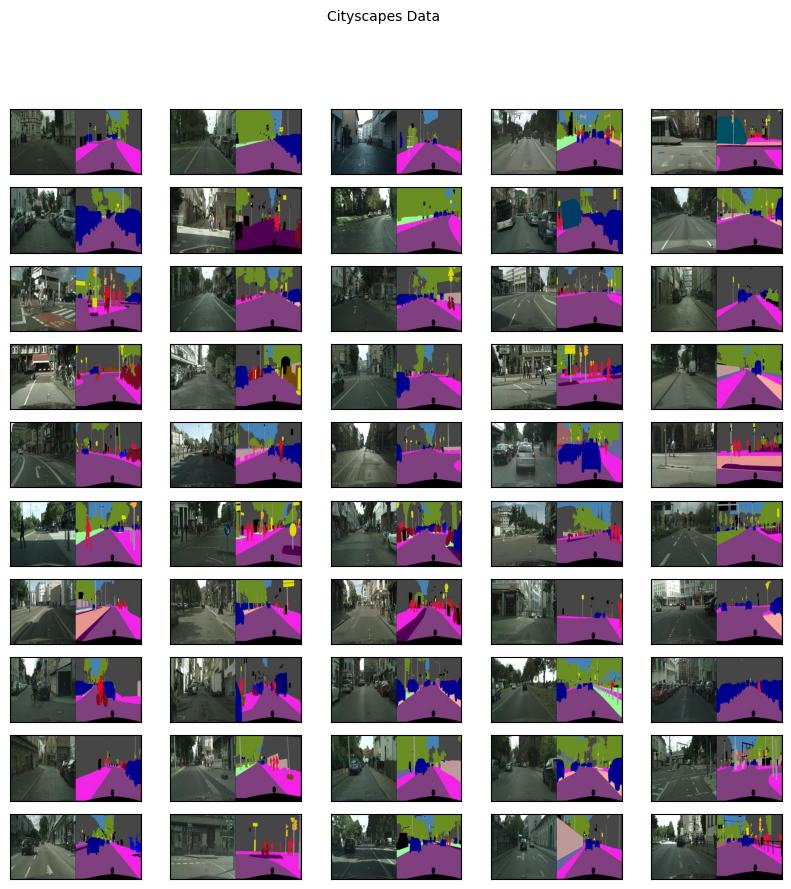

In [39]:
def plot_cityscapes(cityscapes_dir, num=50):
    # Create subplots
    fig, ax = plt.subplots(num // 5, 5, figsize=(10,10))
    img_paths = os.listdir(f'{cityscapes_dir}/train')
    img_paths = [f'{cityscapes_dir}/train/{i}' for i in img_paths]
    # Shuffle
    random.shuffle(img_paths)
    i = 0
    j = 0
    for img_path in img_paths[:num]:
        # Read image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Plot image
        ax[i, j].imshow(img)
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        j += 1
        if j == 5:
            j = 0
            i += 1
    # Add title
    plt.suptitle('Cityscapes Data', fontsize=10)
    plt.show()

plot_cityscapes(cityscapes_dir)

Dataset for CityScapes Dataset

In [40]:
class CityScapesDataset(Dataset):
    def __init__(
        self,
        root_dir: str = cityscapes_dir,
        mode: str = 'train',
        transforms = None,
        ):
        self.data_dir = f'{root_dir}/{mode}'
        self.transforms = transforms

    def _get_image_and_mask(self, path):
        img = cv2.imread(path)
        img = img[:, :, ::-1]
        # First Half of the image is the image
        cropped_img = img[:, :256]
        # Second Half of the image is the mask
        mask = img[:, 256:]
        mask[mask>1] = 1
        return cropped_img, mask

    def __getitem__(self, idx):
        idx += 1
        file_path = f'{self.data_dir}/{idx}.jpg'
        img, mask = self._get_image_and_mask(file_path)
        # Transform if not None
        if self.transforms is not None:
            transformed = self.transforms(image=img.copy(), mask=mask.copy())
            img = transformed['image'].to(torch.float32)
            mask[mask>0] = 1
            mask = transformed['mask'].to(torch.float32)
        return img/255, mask

    def __len__(self):
        return len(os.listdir(self.data_dir))

In [41]:
cityscapes_transforms = A.Compose(
    [
        A.RandomCrop(IMG_H, IMG_W),
        A.CLAHE(p=0.2),
        A.ColorJitter(p=0.2),
        A.RandomGamma(p=0.2),
        A.RGBShift(p=0.2),
        ToTensorV2(),
    ]
)
dataset_cityscapes = CityScapesDataset(transforms=cityscapes_transforms)

### Data Generator

It is a Class initialized by meta dataset and background dataset

In [42]:
generator_config = {
    'dataset_meta': dataset_meta,
    'dataset_background': dataset_cityscapes,
    'df_path': f'{ROOT_DIR}/gtsrb/Generated.csv'
}

generator = SyntheticDataGenerator(**generator_config)

### Generate Images

In [43]:
num_images_to_generate = 50

for class_idx in tqdm(range(NUM_CATEGORIES)):
    gen_imgs = generator.generate(class_idx, num_images_to_generate, True)

  0%|          | 0/43 [00:00<?, ?it/s]

list index out of range skipping image
list index out of range skipping image
list index out of range skipping image
list index out of range skipping image


### Visualize Generated Images

/tmp/ipykernel_53252/860716983.py:5: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  fig.tight_layout(h_pad = 2)


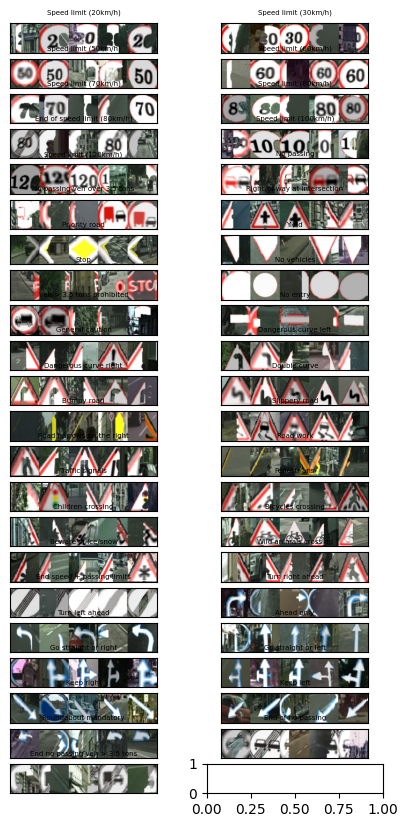

In [44]:
generated_path = f'{ROOT_DIR}/gtsrb/Generated'

def plot_generated():
    fig, ax = plt.subplots(len(CLASSES) // 2 + 1, 2, figsize=(5,10))
    fig.tight_layout(h_pad = 2)

    for i in CLASSES:
        folder_name = f'{generated_path}/{i}'
        filenames = os.listdir(folder_name)
        random.shuffle(filenames)
        concat_imgs = []
        for j in range(5):
            imgName = folder_name + "/" + filenames[j]
            img = cv2.imread(imgName)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (64, 64))
            concat_imgs.append(img)
        concat_img = cv2.hconcat(concat_imgs)
        ax[i//2, (i%2)].imshow(concat_img)
        ax[i//2, (i%2)].set_title(CLASSES[int(i)], fontsize=5)
        ax[i//2, (i%2)].set_yticks([])
        ax[i//2, (i%2)].set_xticks([])
    plt.show()

plot_generated()

#### df for Experiment 3 becomes combination of gtsrb and generated images

In [45]:
combined_df = pd.concat([df_gtsrb, generator.df]).sample(frac=1).reset_index(drop=True)

#### Create Experiment

In [46]:
experiment_3_config = {
    'name': 'experiment_4',
    'df': combined_df,
    'config': {
        'model_config': {
            'name': 'GTSRBModel',
            'weights_path': None,
            'config':{
                'in_channels': 3,
                'output_dim': 43,
            }
        },
        'training_config': {
            'num_epochs': 30,
            'optimizer': {
                'name': 'Adam',
                'config': {
                    'lr': 0.001,
                },
            },
            'criterion': {
                'name': 'CrossEntropyLoss',
                'config': {},
            },
        },
        'dataloading_config': {
            'shuffle': True,
            'batch_size': 64,
            'drop_last': False,
            'num_workers': 2,
        },
        'dataset_config': {
            'sizes': [0.8, 0.2],
            'transforms': train_transform,
        },
        'device': 'cuda',
    }
}

experiment_3 = Experiment(**experiment_3_config)

#### Run Experiment

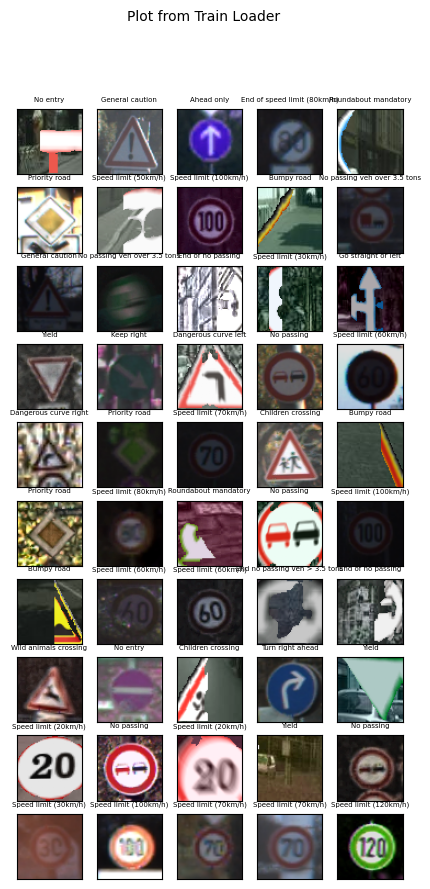

Total Training Samples:  4856


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch-5: 
Training: Loss = 2.2143, Accuracy = 0.3223, Time = 0.56 seconds
Validation: Loss = 1.9535, Accuracy = 0.3781, Time = 0.20 seconds

Epoch-10: 
Training: Loss = 1.1592, Accuracy = 0.6182, Time = 0.56 seconds
Validation: Loss = 1.1000, Accuracy = 0.6425, Time = 0.19 seconds

Epoch-15: 
Training: Loss = 0.7125, Accuracy = 0.7610, Time = 0.56 seconds
Validation: Loss = 0.7466, Accuracy = 0.7743, Time = 0.19 seconds

Epoch-20: 
Training: Loss = 0.5021, Accuracy = 0.8418, Time = 0.56 seconds
Validation: Loss = 0.6481, Accuracy = 0.8089, Time = 0.19 seconds

Epoch-25: 
Training: Loss = 0.3633, Accuracy = 0.8825, Time = 0.55 seconds
Validation: Loss = 0.6111, Accuracy = 0.8221, Time = 0.19 seconds

Epoch-30: 
Training: Loss = 0.2963, Accuracy = 0.9067, Time = 0.55 seconds
Validation: Loss = 0.5420, Accuracy = 0.8501, Time = 0.19 seconds

Testing: Loss = 0.4036, Accuracy = 0.8761
Accuracy and Loss Curves


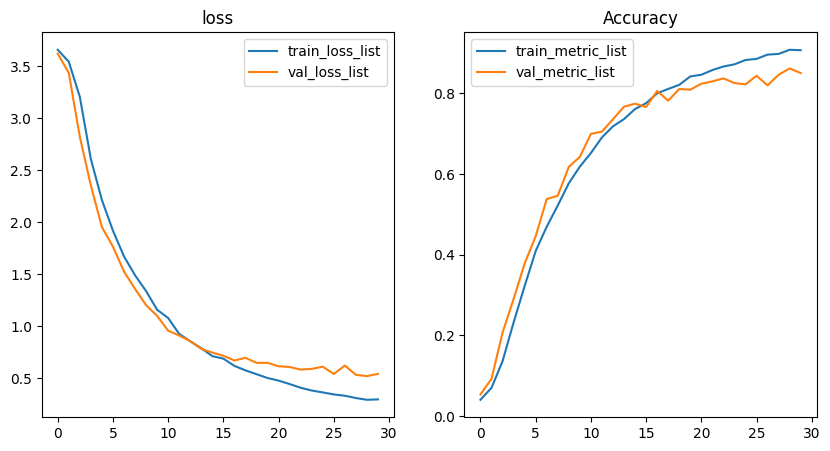

Confusion Matrix on Test Set


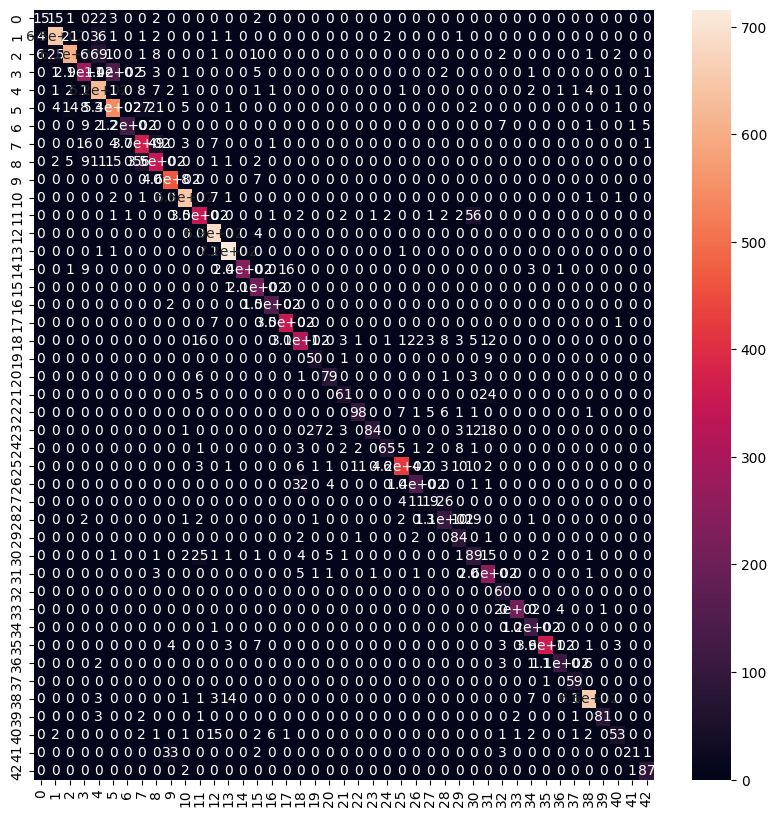

In [47]:
experiment_3.run_experiment()

## Results
- Compare Confusion Matrix
- Compare Accuracy in test set
- Compare all Loss/ Metric Curves

#### 1) Confusion Matrix

Confusion Matrix on Test Set
Confusion Matrix on Test Set
Confusion Matrix on Test Set


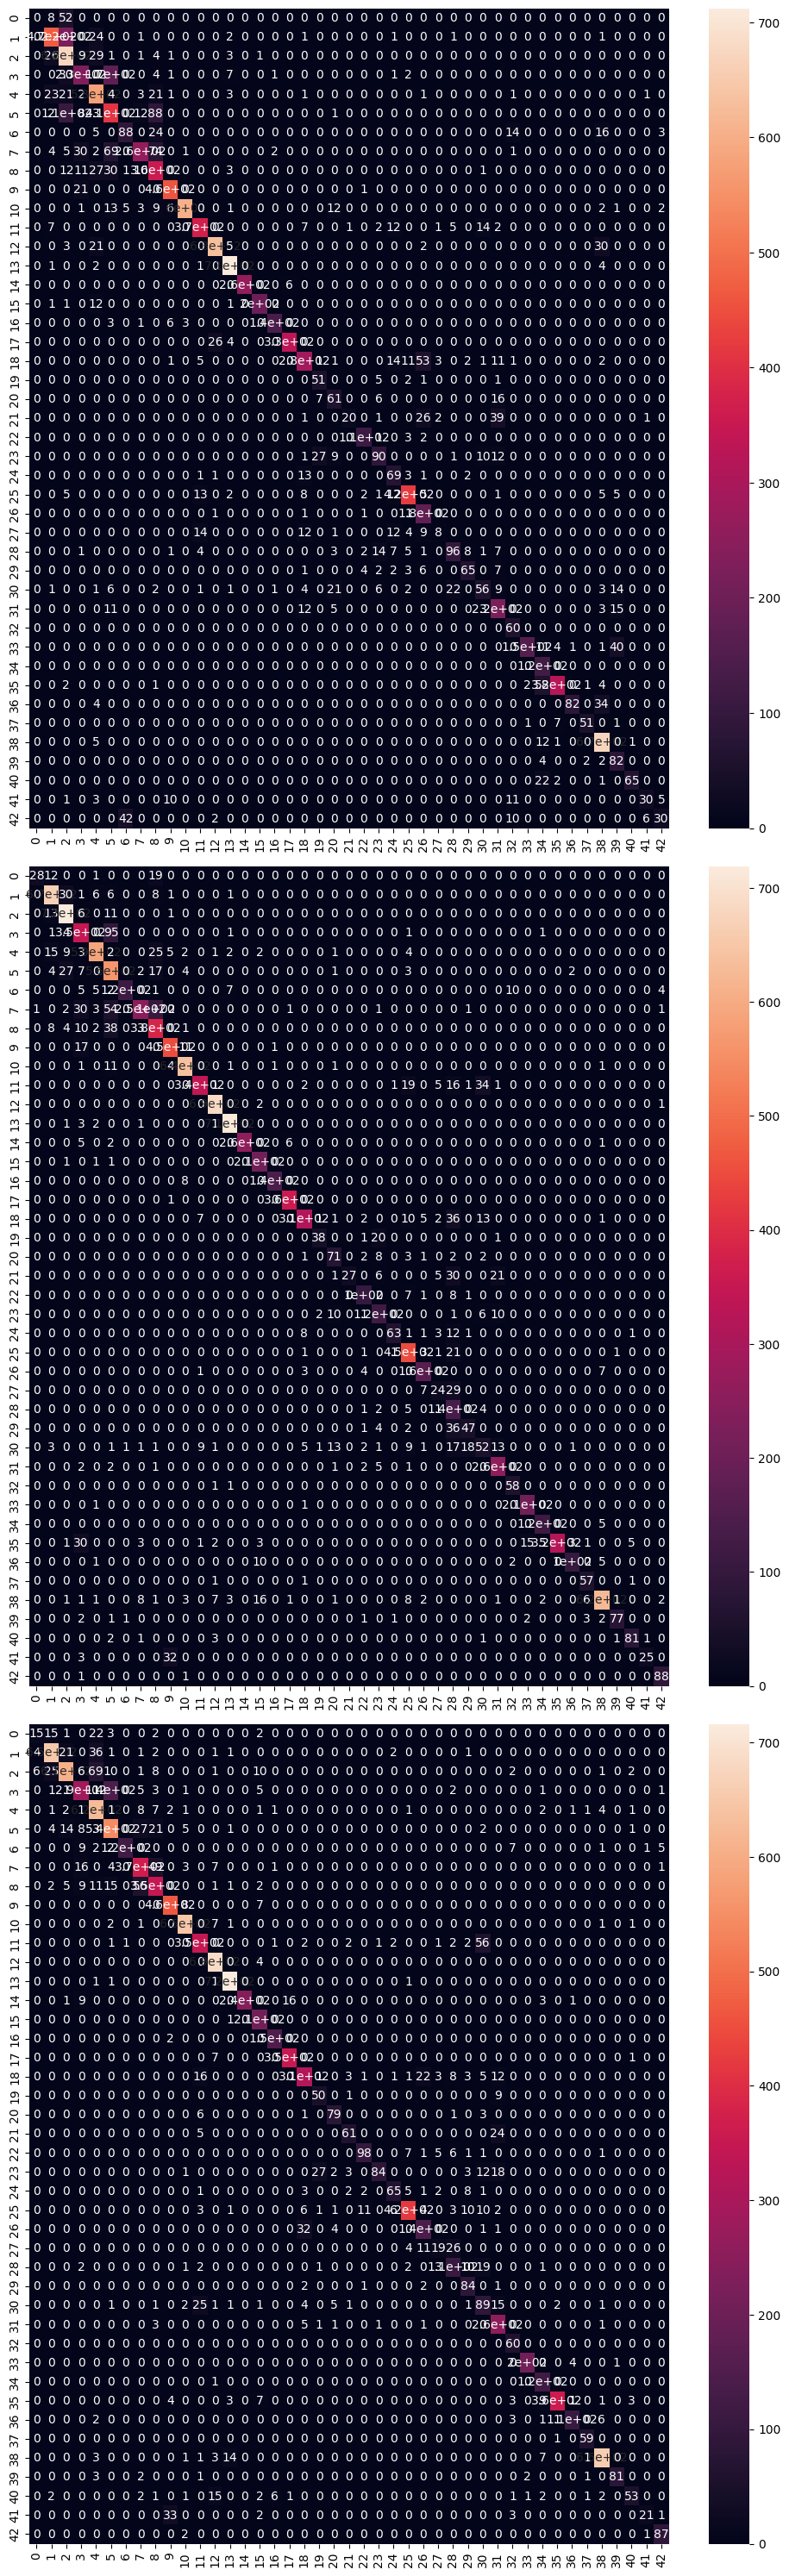

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [62]:
fix, ax = plt.subplots(3,1, figsize=(10, 30))
plt.tight_layout()
experiment_1.plot_confusion_matrix(ax[0])
experiment_2.plot_confusion_matrix(ax[1])
experiment_3.plot_confusion_matrix(ax[2])
plt.show()

#### 2) Compare Accuracies

In [49]:
print(f'Experiment 1 - Loss: {experiment_1.test_loss}, Accuracy: {experiment_1.test_metric}')
print(f'Experiment 2 - Loss: {experiment_2.test_loss}, Accuracy: {experiment_2.test_metric}')
print(f'Experiment 3 - Loss: {experiment_3.test_loss}, Accuracy: {experiment_3.test_metric}')

Experiment 1 - Loss: 0.8210863471031189, Accuracy: 0.8046714067459106
Experiment 2 - Loss: 0.434775710105896, Accuracy: 0.8773555159568787
Experiment 3 - Loss: 0.4036474823951721, Accuracy: 0.8760886788368225


#### 3) Compare Loss Functions

Accuracy and Loss Curves


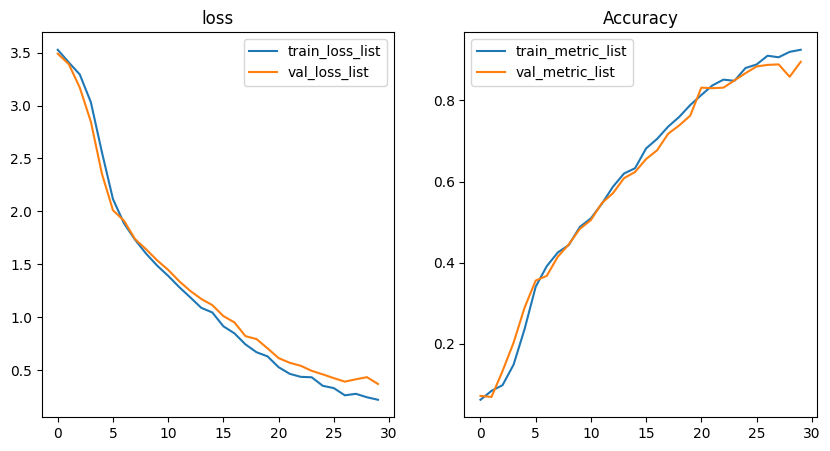

Accuracy and Loss Curves


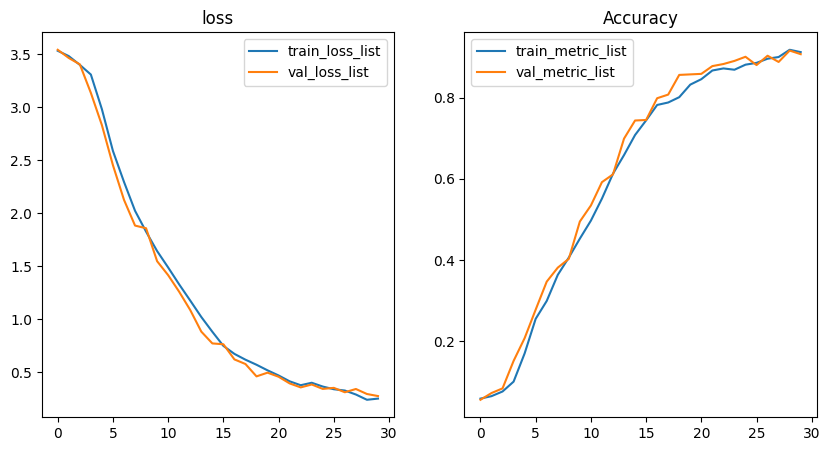

Accuracy and Loss Curves


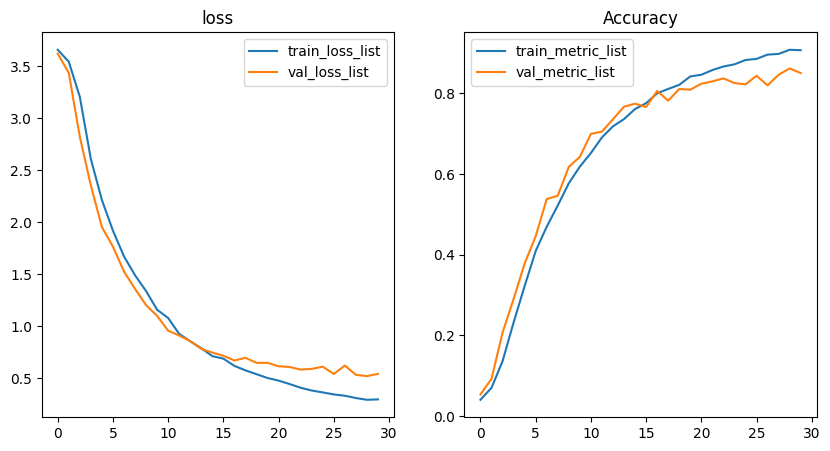

In [50]:
experiment_1.plot_lists()
experiment_2.plot_lists()
experiment_3.plot_lists()

### Run Experiments Multiple Times
Running the experiments multiple times and averaging the results will give us more concrete proof that our data augmentations and data generation had effect on the accuracy

In [51]:
# def run_once(experiment_config):
#     experiment_config['config']['model_config']['weights_path'] = None
#     exp = Experiment(**experiment_config)
#     exp.train()
#     exp.test()
#     return exp

# exp1_list = [run_once(experiment_1_config) for _ in range(10)]
# exp2_list = [run_once(experiment_2_config) for _ in range(10)]
# exp3_list = [run_once(experiment_3_config) for _ in range(10)]

#### Save and Load prev Experiments

In [52]:
# with open(f'{ROOT_DIR}/exp1_list.p', 'wb') as p:
#     pickle.dump(exp1_list, p)

# with open(f'{ROOT_DIR}/exp2_list.p', 'wb') as p:
#     pickle.dump(exp2_list, p)

# with open(f'{ROOT_DIR}/exp3_list.p', 'wb') as p:
#     pickle.dump(exp3_list, p)

with open(f'{ROOT_DIR}/exp1_list.p', 'rb') as p:
    exp1_list = pickle.load(p)

with open(f'{ROOT_DIR}/exp2_list.p', 'rb') as p:
    exp2_list = pickle.load(p)

with open(f'{ROOT_DIR}/exp3_list.p', 'rb') as p:
    exp3_list = pickle.load(p)

#### Get Average of all tests

In [53]:
def get_avg_test_metric(exp_list):
    results = []
    for exp in exp_list:
        test_result = exp.test_metric
        if test_result > 0.5:
            results.append(test_result)
    return sum(results)/ len(results)

print(get_avg_test_metric(exp1_list))
print(get_avg_test_metric(exp2_list))
print(get_avg_test_metric(exp3_list))

0.8307600915431976
0.8787094235420227
0.8826840698719025


### Plotting Histories

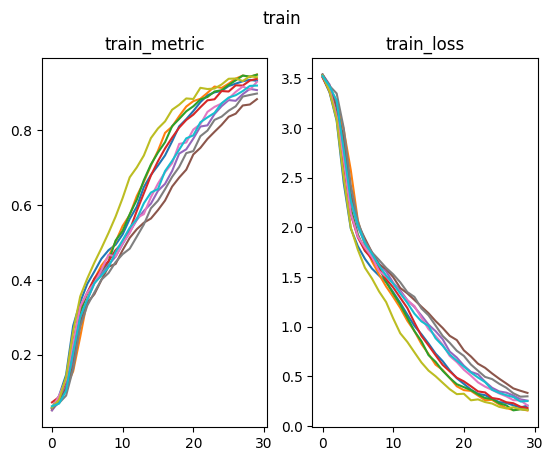

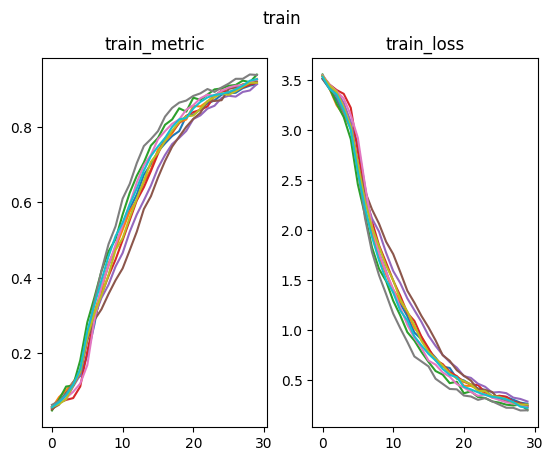

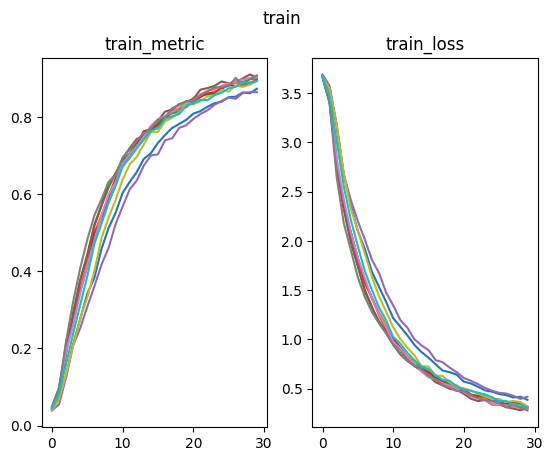

In [54]:
def plot_histories(exp_list, which='train'):
    fig, ax = plt.subplots(1,2)
    for exp in exp_list:
        match which:
            case 'train':
                ax[0].plot(exp.train_metric_list)
                ax[1].plot(exp.train_loss_list)
            case 'val':
                ax[0].plot(exp.val_metric_list)
                ax[1].plot(exp.val_loss_list)
    ax[0].set_title(f'{which}_metric')
    ax[1].set_title(f'{which}_loss')
    plt.suptitle(which)
    plt.show()

plot_histories(exp1_list, 'train')
plot_histories(exp2_list, 'train')
plot_histories(exp3_list, 'train')

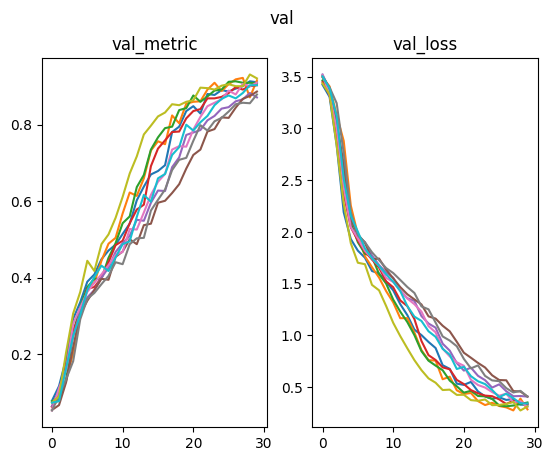

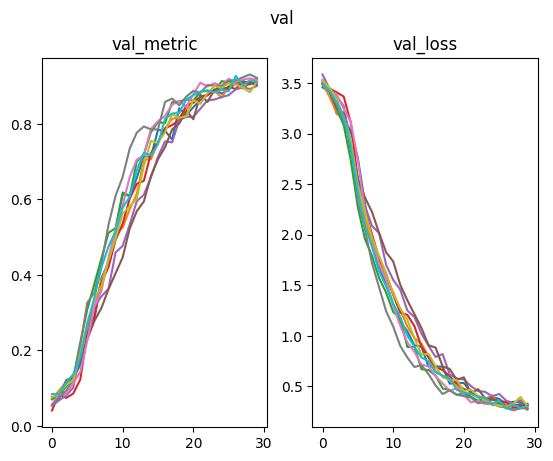

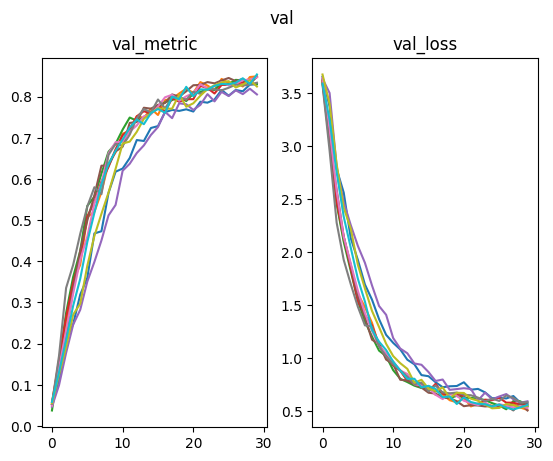

In [55]:
plot_histories(exp1_list, 'val')
plot_histories(exp2_list, 'val')
plot_histories(exp3_list, 'val')

### Task for students
- Try to improve Accuracy by tuning hyperparameters and/ or changing the model architecture
- Rules:
    - No pretrained weights allowed
    - No more data generation allowed

In [56]:
# class CustomModel(nn.Module):
#     def __init__(self, in_channels, output_dim, **kwargs):
#         super().__init__()
#         self.features = nn.Sequential(
#                             ...
#                         )

#         self.classifier = nn.Sequential(
#                             ...
#                         )

#     def forward(self, x):
#         x = self.features(x)
#         h = x.view(x.shape[0], -1)
#         x = self.classifier(h)
#         return x

In [57]:
# # Define your own data
# custom_df = pd.DataFrame()

In [58]:
# # Define your own transforms
# custom_transforms = A.Compose(
#     [
#         ...
#     ]
# )

In [59]:
# experiment_custom_config = {
#     'name': 'experiment_3',
#     'df': custom_df,
#     'config': {
#         'model_config': {
#             'name': 'CustomModel',
#             'weights_path': None,
#             'config':{
#                 ...
#             }
#         },
#         'training_config': {
#             'num_epochs': ...,
#             'optimizer': {
#                 ...
#             },
#             'criterion': {
#                 ...
#             },
#         },
#         'dataloading_config': {
#             'shuffle': True,
#             'batch_size': ...,
#             'drop_last': False,
#             'num_workers': 8,
#         },
#         'dataset_config': {
#             'sample': 0.2,
#             'sizes': [0.8, 0.2],
#             'transforms': custom_transforms,
#         },
#         'device': ...,
#     }
# }

# experiment_4 = Experiment(**experiment_custom_config)

## Resources:
- GTSRB: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/data
- CityScapes: https://www.kaggle.com/datasets/dansbecker/cityscapes-image-pairs/data
- Synthetic Data Generator: https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=6287592
- Albumentations: https://albumentations.ai/docs/api_reference/full_reference/
- Pytorch Models: https://pytorch.org/vision/stable/models.html
- Pytorch optim: https://pytorch.org/docs/stable/optim.html
- Pytorch nn: https://pytorch.org/docs/stable/nn.html

---
---